In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib
cmap = matplotlib.colormaps.get('tab10').colors
import matplotlib.pyplot as plt
plt.style.use('fullwidth.mplstyle')
import torch
import torch_geometric as tg
from tqdm import trange
from scipy.spatial import KDTree
import networkx as nx
import os

In [18]:
class PlaneAutoencoderDataset(tg.data.Dataset):
    '''
    This class bundles the creation and saving as well as loading of a dataset of the plane graphs used for defect detection. If an instance is created, the class will check in root directory if the dataset is already processed. If not, the process() method will be called. Furthermore, the dataset will be loaded. If the dataset shall be calculated again, the process() method must be called explicitely.
    '''
    def __init__(self, root, n_graphs_per_type=100, transform=None, pre_transform=None, size=(5,5)):
        '''
        Args:
        - root (str): The directory where the dataset should be stored, divided into processed and raw dirs
        - n_graphs_per_type (int): The number of graphs per lattice type that should be created
        '''
        self.root = root
        self.n_graphs_per_type = n_graphs_per_type
        self.size = size    
        super().__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        '''
        If this file exists in the raw directory, the download will be skipped. Download not implemented.
        '''
        return 'raw.txt'
    
    @property
    def processed_file_names(self):
        '''
        If this file exists in the processed directory, processing will be skipped. 
        '''
        return ['data_00000.pt']
    
    def download(self):
        '''
        Download not implemented.
        '''
        pass
    
    def len(self):
        '''
        Returns the number of graphs in the dataset.
        '''
        return len([f for f in os.listdir(os.path.join(self.root, 'processed')) if f.startswith('data')])
    
    def get(self, idx):
        '''
        Returns the graph at index idx. 
        '''
        data = torch.load(os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(idx)))
        return data
    
    def process(self):
        '''
        Here creation, processing and saving of the dataset happens. 
        '''
        planeGraph = PlaneGraphGenerator(size=self.size) # Create the planeGraph object (basically only a collection of methods, same for all graphs)
        for n in trange(self.n_graphs_per_type * 5):
            pos, edge_index, label, node_attr, edge_attr = planeGraph.process_lattice(planeGraph.lattice_types[n % 5])
            # Create data object:
            data = tg.data.Data(x          = torch.tensor(node_attr, dtype=torch.float), 
                                edge_index = torch.tensor(edge_index, dtype=torch.int64), 
                                y          = torch.tensor(label, dtype=torch.float), 
                                pos        = torch.tensor(pos, dtype=torch.float),
                                edge_attr  = torch.tensor(edge_attr, dtype=torch.float))
            # Save data object:
            torch.save(data, os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(n)))

class PlaneGraphGenerator():
    def __init__(self, size=(5,5)):
        '''
        Args:
        - size (tuple): The size of the lattice in x,y direction. The lattice will be (roughly) size[0] x size[1] large.
        '''
        self.size = np.array(size) + 3 # Add 3 to each dimension to have padding around the lattice for the BOO calculation
        self.lattice_types = {
            # The lattice types are defined by the following parameters (see also process_lattice()):
            0: {'name': 'mP', 'nodes': self._get_P_nodes, 'binding_angle':   0, 'scale': [0, 0]},
            1: {'name': 'oP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            2: {'name': 'oC', 'nodes': self._get_C_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            3: {'name': 'tP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [1, 1]},
            4: {'name': 'hP', 'nodes': self._get_P_nodes, 'binding_angle': 120, 'scale': [1, 1]}
        }
        
    def process_lattice(self, arg_dict):
        '''
        Method that processes a lattice of a given type. The method is called with a dictionary holding parameters for one of the lattice types. It contains the following keys:
            - name: The name of the lattice type
            - nodes: The method to get the fitting fundamental lattice nodes
            - binding_angle: binding angle alpha of the lattice type. angle are in degrees. 0° means to generate a independent random angle (0,180)°
            - scale: A list of scaling factors [x,y] for the lattice type. 0 means to generate a random scaling factor (0,2)
        '''
        # Get lattice angles
        angle = arg_dict['binding_angle']
        if angle == 0:
            angle = rng.uniform(46,89,1)
            
        # Get the fundamental lattice nodes
        if arg_dict['name'] in ['hP']:
            # For hP lattice we need to give the angle to the nodes method so that sheared connections are equally long
            nodes = arg_dict['nodes'](angle)
        else:
            nodes = arg_dict['nodes']()
    
        inside_mask = self._get_inside_mask(nodes) # Mask of nodes without padding for later use
        nodes = self._shear_nodes(nodes, angle) # Shear the nodes to create other lattice types 
        
        # Find random scale and apply gaussian noise to the lattice accordingly
        scale = np.array(arg_dict['scale'])
        scale = np.where(scale == 0, rng.uniform(0.3,3,2), scale)
        
        # We add a defect by displacing one node, here labels are created
        nodes, labels, inside_mask = self._displace_node(nodes, inside_mask)
        
        cons = self._get_cons_in_radius(nodes, 1.3)  # Find the connections between the nodes in a given radius
        nodes *= scale  # Apply the saved scaling
        node_attr = self._get_node_attr(nodes, cons) # Get the node attributes
        nodes, labels, node_attr = nodes[inside_mask], labels[inside_mask], node_attr[inside_mask] # Remove padding nodes
        
        # As we removed nodes, we need to recalculate the connections and get their attributes
        cons = self._get_cons_in_radius(nodes, 1.3) 
        edge_attr = self._get_edge_attr(nodes, cons)
        return nodes, cons, labels, node_attr, edge_attr
    
    # -----------
    # Helper methods, not intended to be called from outside:
    # -----------
    
    def _get_P_nodes(self, angle=90):
        '''
        Get the nodes of a primitive lattice.
        '''
        scaling = np.sin(np.radians(angle))
        vec1 = np.arange(0,self.size[0])
        vec2 = np.arange(0,self.size[1])*scaling
        a, b = np.meshgrid(vec1,vec2)
        nodes = np.stack([a,b],axis=-1) # Stack them in a new axis
        nodes = np.reshape(nodes, (-1, 2)) # Reshape to an arr of nodes with shape (#nodes, 2)
        return nodes

    def _get_C_nodes(self):
        '''
        Get the nodes of a centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + np.array([0.5,0.5])
        return np.row_stack((P, extra))

    def _displace_node(self, nodes, inside_mask):
        '''
        Method that dislaces one random node in the lattice by a random amount. Returns the new nodes and the label for classification. 
        The label is a one hot encoded array of shape (len(nodes)) where 1 markes the index od the displaced node.
        '''
        # Get random inside node 
        allowed_indices = np.where(inside_mask)[0]
        node_ind = rng.choice(allowed_indices)
        # Get random displacement
        displacement = rng.normal(0, 1, 2)
        # Assert that the displacement does not move the node out of the lattice (roughly)
        while np.any(nodes[node_ind] + displacement < np.min(nodes[inside_mask], axis=0)) or np.any(nodes[node_ind] + displacement > np.max(nodes[inside_mask], axis=0)):
            displacement = rng.normal(0, 1, 2)
            
        # Insert displaced node, fix inside_mask, get label
        nodes = np.insert(nodes, node_ind, nodes[node_ind] + displacement, axis=0)
        inside_mask = np.insert(inside_mask, node_ind, True)
        labels = np.zeros(len(nodes))
        labels[node_ind] = 1
        return nodes, labels.reshape(-1,1), inside_mask
    
    def _get_cons_in_radius(self, nodes, radius):
        '''
        Returns the connections in a given radius.
        '''
        tree = KDTree(nodes)
        cons = tree.query_pairs(radius, output_type='ndarray', p=2)
        cons = cons.T
        cons = np.column_stack((cons, cons[::-1])) # Add the reverse connections
        return cons

    def _shear_nodes(self, nodes, binding_angle):
        '''
        Shear nodes by binding angle.
        '''
        delta = np.tan(np.radians(binding_angle))
        assert not np.any(delta == 0), 'Binding angle cannot be 0'
        nodes = nodes.astype(float)
        nodes = nodes + np.stack((nodes[:,1]/delta, np.zeros_like(nodes[:,1])), axis=1)
        return nodes
        
    def _get_node_attr(self,nodes,cons):
        '''
        Method that returns the node attributes for each node in the graph. Should be called after creating the graph and adding defects.
        The node attributes have the shape (num_nodes, num_node_features). For each node, the node features are the following:
        - The bond orientational order parameters for l=2,4,6,8,10 (5 features)
        - The number of neighbors (1 feature)
        '''
        # Initialise a graph object to get the neighbors of each node
        G = nx.Graph()
        G.add_edges_from(cons.T)
        
        # Calculate the BOO and NN for each node
        boo_arr = np.zeros((len(nodes), 5), dtype=complex)
        n_neighbors = np.zeros(len(nodes))
        for i in range(len(nodes)):
            # Check if node is connected to any other node, if yes BOO=NN=0
            if i not in G.nodes:
                boo_arr[i] = np.zeros(5)
                n_neighbors[i] = 0
                continue
            
            # iterate over all neighbopuring nodes
            neighbors = list(G.neighbors(i))
            n_neighbors[i] = len(neighbors)
            
            # calculate the bond orientational order parameters for l=2,4,6,8,10
            boo_ = np.zeros(5, dtype=complex)
            for n in neighbors:
                angle = np.arctan2(nodes[n,1] - nodes[i,1], nodes[n,0] - nodes[i,0])
                boo_ += np.array([np.exp(1j*2*angle), np.exp(1j*4*angle), np.exp(1j*6*angle), np.exp(1j*8*angle), np.exp(1j*10*angle)])   
            boo_arr[i] = np.abs(boo_ / len(neighbors)) 
        boo_arr = np.real(boo_arr)
        return np.column_stack((boo_arr, n_neighbors))
        
    def _get_edge_attr(self,nodes,cons):
        '''
        Method that returns the edge attributes for each edge in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(edge_index[0])= #Edges, 1) with the length of each edge.
        '''
        # Get the edge vectors for each edge
        edge_vectors = nodes[cons[0]] - nodes[cons[1]]
        return np.linalg.norm(edge_vectors, axis=1).reshape(-1,1)   
    
    def _get_inside_mask(self, nodes):
        '''
        Method that returns the indices of the inside nodes of the lattice. 
        '''
        mask = np.any(np.logical_or(nodes < np.array([1,1]), nodes >= self.size-3), axis=1)
        return ~mask
 

def plot(nodes, cons, labels=None, scores=None):
    fig, ax = plt.subplots()
    ax.scatter(nodes[:,0], nodes[:,1], c='black')
    for con in cons.T:
        ax.plot(nodes[con,0], nodes[con,1], c='black')
    labels = labels.flatten()
    if labels is not None:
        ax.plot(nodes[labels==1,0], nodes[labels==1,1], c='red', markersize=10, marker='o', linestyle='None')
    if scores is not None:
        ax.plot(nodes[np.argmax(scores),0], nodes[np.argmax(scores),1], c='blue', markersize=10, marker='x')
    ax.set_aspect('equal')
    ax.grid()

In [19]:
n = 250
dataset = PlaneAutoencoderDataset("autoencoder_graphs", n_graphs_per_type=n, size=(10,10))
dataset.process()
dataset[0]

100%|██████████| 1250/1250 [00:43<00:00, 28.73it/s]
C:\Users\steph\AppData\Local\Temp\ipykernel_4284\2864953125.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Data(x=[82, 6], edge_index=[2, 1052], edge_attr=[1052, 1], y=[82, 1], pos=[82, 2])

# NN-cells GINE and GCNCon

In [ ]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.4 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 5))
        self.encoder.append(tg.nn.GCNConv(5,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,5))
        self.attr_decoder.append(tg.nn.GCNConv(5,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def anomaly_score(x, x_, adj, adj_):
    return alpha * torch.linalg.norm(x-x_, dim=1) + (1-alpha) * torch.linalg.norm(adj-adj_, dim=1)

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 37
msg = 'GCNConv, optimal'
for i in range(20):    
    model = dominant()
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        print(score/ len(test_loader.dataset))
        score_list.append(score / len(test_loader.dataset))
        # np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

In [ ]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 3), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        # self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            # z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            # x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')
def anomaly_score(x, x_, adj, adj_):
    return alpha * torch.linalg.norm(x-x_, dim=1) + (1-alpha) * torch.linalg.norm(adj-adj_, dim=1)

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 25
msg = 'GINEConv, alpha 0.5, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        # np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

## Plotting:

In [13]:
def plot_boo(nodes, boo, which=0, labels=None, scores=None):
    fig, ax = plt.subplots()
    cbar = ax.scatter(nodes[:,0], nodes[:,1], c=boo[:,which], cmap='viridis')
    # show colorbar
    fig.colorbar(cbar, shrink=0.6)
    labels = labels.flatten()
    if labels is not None:
        ax.plot(nodes[labels==1,0], nodes[labels==1,1], c='black', markersize=10, marker='+')
    if scores is not None:
        ax.plot(nodes[np.argmax(scores),0], nodes[np.argmax(scores),1], c='red', markersize=10, marker='x')
    ax.set_aspect('equal')
    ax.grid()

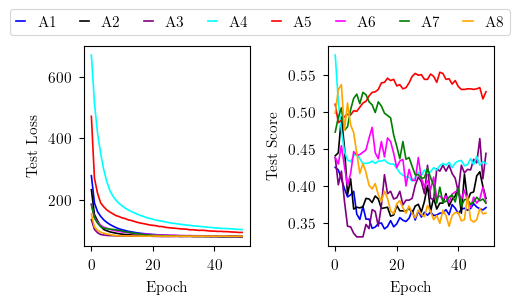

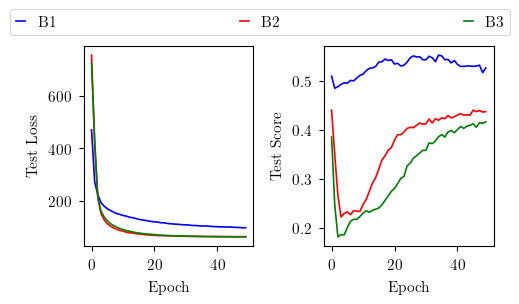

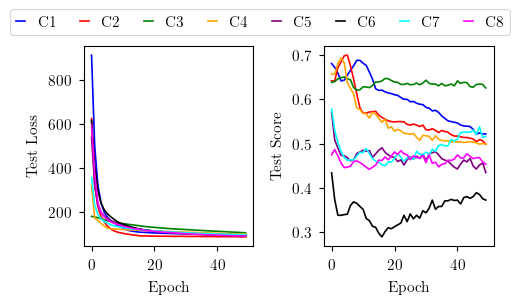

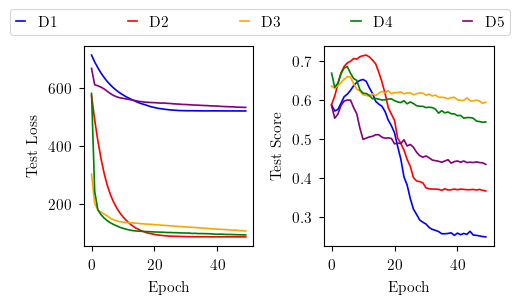

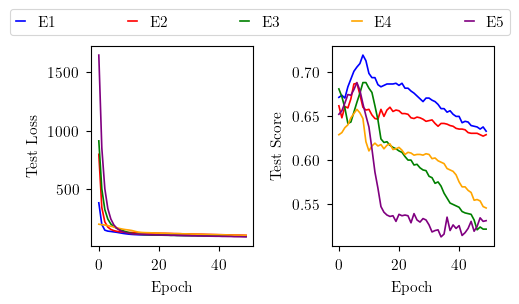

In [3]:
def plot_trajectories(fig, ax, test_index, color, label=None):
    av_train_loss = 0
    av_test_loss = 0
    av_score = 0
    for i in range(5):
        train_loss, test_loss, score = np.loadtxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', unpack=True)
        av_train_loss += train_loss
        av_test_loss += test_loss
        av_score += score
    ax[0].plot(av_test_loss/5, color=color, label = label)
    ax[1].plot(av_score/5, color=color)
    ax[0].set_xlabel('Epoch')
    ax[1].set_xlabel('Epoch')
    ax[0].set_ylabel('Test Loss')
    ax[1].set_ylabel('Test Score')
    
    
fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 1, 'blue', 'A1')
plot_trajectories(fig, ax, 6, 'black', 'A2')
plot_trajectories(fig, ax, 5, 'purple', 'A3')
plot_trajectories(fig, ax, 7, 'cyan', 'A4')
plot_trajectories(fig, ax, 2, 'red', 'A5')
plot_trajectories(fig, ax, 8, 'magenta', 'A6')
plot_trajectories(fig, ax, 3, 'green', 'A7')
plot_trajectories(fig, ax, 4, 'orange', 'A8')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left', ncols=8, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
# fig.savefig('latex/images/plots/defect_detection_A.pdf', bbox_inches='tight')


fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 2, 'blue', 'B1')
plot_trajectories(fig, ax, 10, 'red', 'B2')
plot_trajectories(fig, ax, 12, 'green', 'B3')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left', ncols=3, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
# fig.savefig('latex/images/plots/defect_detection_B.pdf', bbox_inches='tight')


fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 21, 'blue', 'C1')
plot_trajectories(fig, ax, 22, 'red', 'C2')
plot_trajectories(fig, ax, 23, 'green', 'C3')
plot_trajectories(fig, ax, 24, 'orange', 'C4')
plot_trajectories(fig, ax, 25, 'purple', 'C5')
plot_trajectories(fig, ax, 26, 'black', 'C6')
plot_trajectories(fig, ax, 27, 'cyan', 'C7')
plot_trajectories(fig, ax, 28, 'magenta', 'C8')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left', ncols=8, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
# fig.savefig('latex/images/plots/defect_detection_C.pdf', bbox_inches='tight')


fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 13, 'blue', 'D1')
plot_trajectories(fig, ax, 14, 'red', 'D2')
plot_trajectories(fig, ax, 16, 'orange', 'D3')
plot_trajectories(fig, ax, 15, 'green', 'D4')
plot_trajectories(fig, ax, 17, 'purple', 'D5')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
# fig.savefig('latex/images/plots/defect_detection_D.pdf', bbox_inches='tight')


fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 29, 'blue', r'E1')
plot_trajectories(fig, ax, 30, 'red', r'E2')
plot_trajectories(fig, ax, 21, 'green', r'E3')
plot_trajectories(fig, ax, 31, 'orange', r'E4')
plot_trajectories(fig, ax, 32, 'purple', r'E5')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
# fig.savefig('latex/images/plots/defect_detection_E.pdf', bbox_inches='tight')
